In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print("Reading the data...")
data = pd.read_csv('/content/drive/MyDrive/CS7150_files/lecture_0120/MNIST/train.csv', sep=",")
test_data = pd.read_csv('/content/drive/MyDrive/CS7150_files/lecture_0120/MNIST/test.csv', sep=",")


print("Reshaping the data...")
dataFinal = data.drop('label', axis=1)
labels = data['label']

dataNp = dataFinal.to_numpy()
labelsNp = labels.to_numpy()
test_dataNp = test_data.to_numpy()

print("Data is ready")

train_data, val_data, train_labels, val_labels = train_test_split(dataNp, labelsNp, test_size=0.1)

# Convert to torch tensors
x_train = torch.FloatTensor(train_data.tolist())
y_train = torch.LongTensor(train_labels.tolist())
x_val = torch.FloatTensor(val_data.tolist())
y_val = torch.LongTensor(val_labels.tolist())

# print data sizes
print(f"train size: {list(x_train.shape)}")
print(f"validation size: {list(x_val.shape)}")
print(f"test size: {list(test_dataNp.shape)}")

Reading the data...
Reshaping the data...
Data is ready
train size: [37800, 784]
validation size: [4200, 784]
test size: [28000, 784]


8  /  9
8  /  4
9  /  1


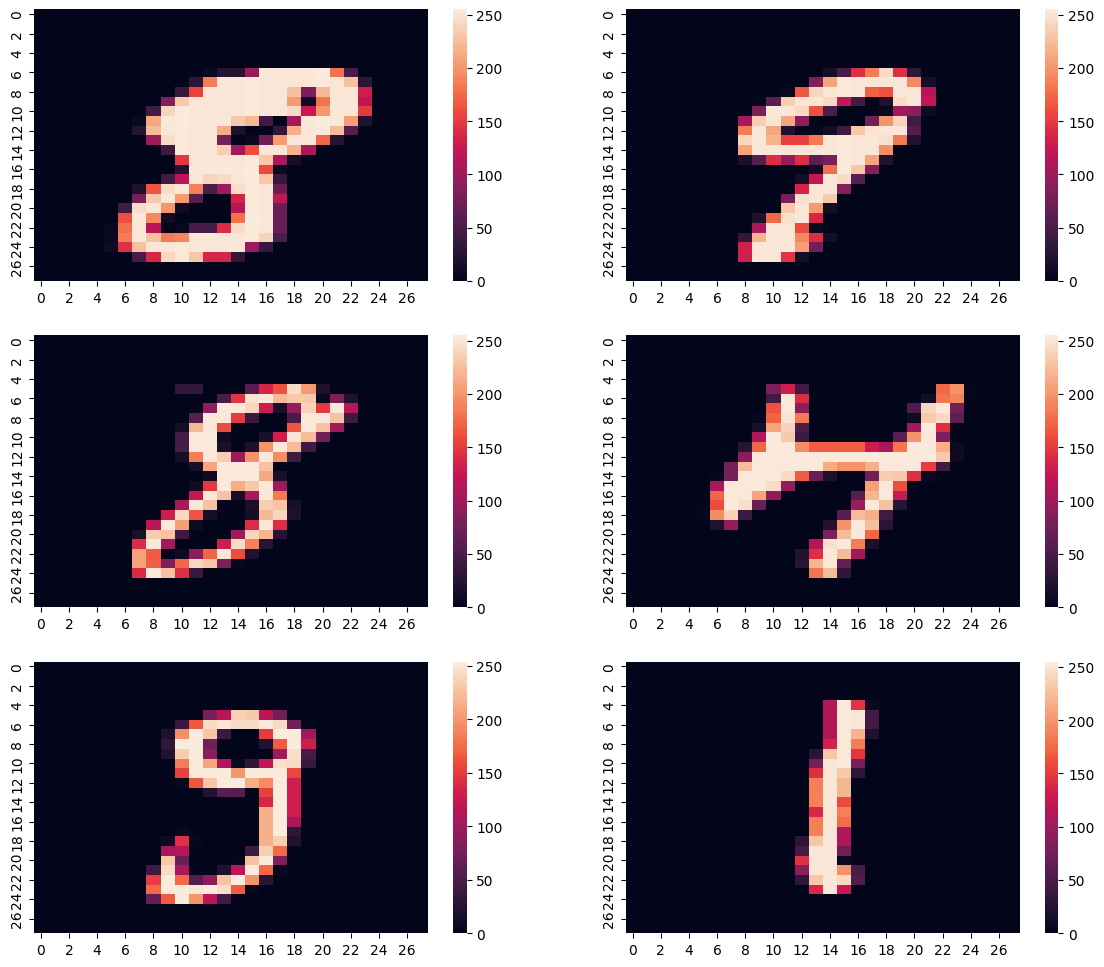

In [4]:
plt.figure(figsize=(14, 12))

pixels = dataNp[10].reshape(28, 28)
plt.subplot(321)
sns.heatmap(data=pixels)

pixels = dataNp[11].reshape(28, 28)
plt.subplot(322)
sns.heatmap(data=pixels)

pixels = dataNp[20].reshape(28, 28)
plt.subplot(323)
sns.heatmap(data=pixels)

pixels = dataNp[32].reshape(28, 28)
plt.subplot(324)
sns.heatmap(data=pixels)

pixels = dataNp[40].reshape(28, 28)
plt.subplot(325)
sns.heatmap(data=pixels)

pixels = dataNp[52].reshape(28, 28)
plt.subplot(326)
sns.heatmap(data=pixels)

print(labels[10], " / ", labels[11])
print(labels[20], " / ", labels[32])
print(labels[40], " / ", labels[52])


In [5]:
input_size = 784
output_size = 10
hidden_size = 200

epochs = 20
batch_size = 50
learning_rate = 0.00005

In [6]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l3(x)
        return F.log_softmax(x)

In [7]:
net = Network().to(0)
print(net)

Network(
  (l1): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (l3): Linear(in_features=200, out_features=10, bias=True)
)


In [8]:
!nvidia-smi

Sat Jan 20 19:37:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              26W /  70W |    105MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

In [10]:
loss_log = []
val_loss_log = []
epoch_size = x_train.shape[0] // batch_size

for e in range(epochs):
    # Training
    for i in range(0, x_train.shape[0], batch_size):
        x_mini = x_train[i:i + batch_size]
        y_mini = y_train[i:i + batch_size]

        x_var = Variable(x_mini).to(0)
        y_var = Variable(y_mini).to(0)

        optimizer.zero_grad()
        net_out = net(x_var)
        loss = loss_func(net_out, y_var)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

    # Validation
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, x_val.shape[0], batch_size):
            x_mini_val = x_val[i:i + batch_size]
            y_mini_val = y_val[i:i + batch_size]

            x_var_val = Variable(x_mini_val).to(0)
            y_var_val = Variable(y_mini_val).to(0)

            net_out_val = net(x_var_val)
            val_loss += loss_func(net_out_val, y_var_val).item()

    val_loss_log.append(val_loss / (x_val.shape[0] / batch_size))


<ipython-input-6-68143d838ddf>:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


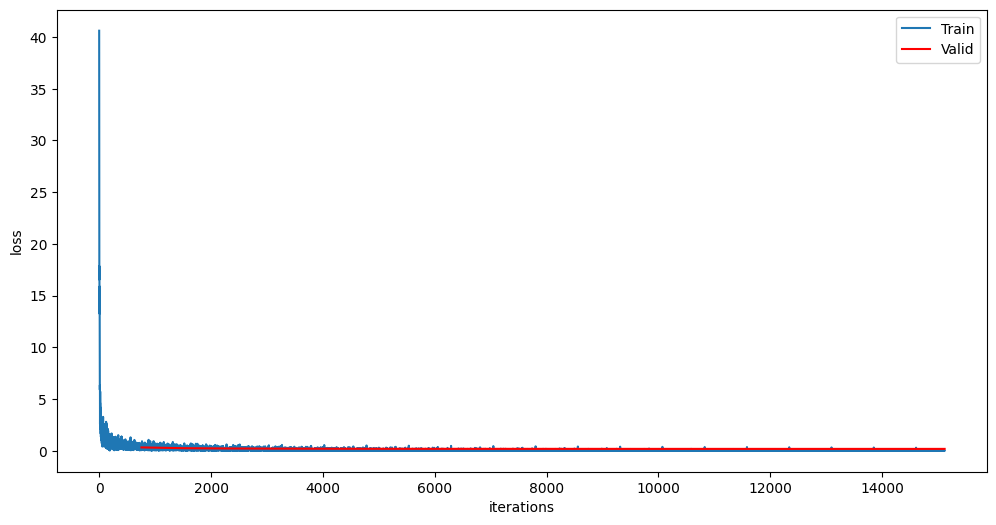

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(loss_log, label='Train')
plt.plot(epoch_size*np.arange(1, 1+epochs), val_loss_log, label='Valid', color='red')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()


In [13]:
test = torch.FloatTensor(test_dataNp.tolist())
test_var = Variable(test).to(0)

net_out = net(test_var)

print(torch.max(net_out.data.cpu(), 1)[1].numpy())

[2 0 9 ... 3 9 2]


<ipython-input-6-68143d838ddf>:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
